# 変分ベイズでノンパラベイズ(Dirichlet process infinite mixture model)

ノンパラベイズがしたいのですが難しいので困っている。とりあえず下のような参考文献を集めた。

1. Lin (2000)
  - MCMCでノンパラベイズ
2.  Blei and Jordan (2004)とか
  - 変分ベイズでノンパラベイズ, SBPでtruncated approximationするとか何とか?

上を読みたいのですが難しくてよくわかりません. 英語だし. しょうがないので簡単そうなものを探して読むことにした.

[Lin 2013](http://papers.nips.cc/paper/4968-online-learning-of-nonparametric-mixture-models-via-sequential-variational)という論文を見つけたので読んで実装する. この論文の手法は, Variational inference, コンポーネント数Kを動的に更新する, sequential dataに適用できる, online machine learningできる, MCMCを含めた他の手法と比較して高速かつ高性能, らしい.

## Sequential Approximation

以下のようなことをやっているようです. $ \mu $ はDirichlet process の基底分布, $ C_k $ はk番目のコンポーネントのデータ数. 隠れ変数$ z_{ik} $ を $ \rho_i(k) $ で近似.

1. $p\left(z_{1:n} \mid x_{1:n} \right)$を因子分解可能とし, $ \prod_{i=1}^n \rho_i\left(z_i \right)$ で近似
2. コンポーネントkのパラメータの事後分布 $\mu |_{C_k}$ を $\nu_k$ で近似

## 処理の流れ

$ x_i, i=1,2,3,... $ に対して推定する.

### 1. i == 1のとき

コンポーネント数 $ K=1 $, $\rho_1(1) = 1$ ( $x_1$ のコンポーネント1へのresponsibilityが1) とする. コンポーネント1のi=1の時点でのパラメータ$\nu_{k=1}^{(i=1)}$ は以下とする. $F$はデータが従う分布.

$$
\nu_1^{(1)} \propto \mu(d\theta) F(x_1 \mid \theta)
$$


### 2. i > 1のとき

キモは(15)式と(16)式. (15) は要するに　$x_{i+1} $の事後予測分布の各コンポーネントごとでの尤度比を $\rho$にしている.

$$
\tag{15}
\rho_{i+1} \propto \left\{ \begin{array}{ll}
    w_k^{(i)} \int_\theta F\left( x_{i+1} \mid \theta \right) \nu_k^{(i)} \left( d \theta \right) & (k \le K), \\
    \alpha \int_\theta F\left( x_{i+1} \mid \theta \right) \mu \left( d \theta \right) & (k = K+1), \\
  \end{array} \right.
$$

with $ w_i^{(i)} = \sum_{j=1}^i \rho_j\left(k \right)$, and 

$$
\tag{16}
\nu_{k}^{(i+1)}\left( d\theta \right) \propto \left\{ \begin{array}{ll}
    \mu\left( d\theta \right) \prod_{j=1}^{i+1} F\left( x_j \mid \theta \right)^{\rho_j(k)}
    & (k \le K), \\
    \mu\left( d\theta \right) F\left( x_{i+1} \mid \theta \right)^{\;\rho_{i+1}(k)}
    & (k = K+1), \\
  \end{array} \right.
$$

手順としては, $i$を増やすたびに, $\rho_{i+1}$の計算, $w_k$ の更新, Kの更新と$\nu$の更新を繰り返す. Kをインクリメントするかどうかは, $\rho_{i+1}\left( K+1 \right) $ がしきい値以上であるか否かで判定する. Kをインクリメントしない場合は, $\rho_{i+1}\left( K+1 \right) $は不要なので削除, $\rho_{i+1}\left( 1,..., K \right) $の総和が1になるように標準化する.

他に, 各i のイテレーションでコンポーネントのprune and mergeをすると推定結果がよりよくなると書かれている. pruneは $w_k$の低いコンポーネントkを削除する. mergeはコンポーネントk1とコンポーネントk2について$ i^{-1} \times \sum_{j=1}^{i} \mid \rho_j(k1) - \rho_j(k2) \mid$ がしきい値より低い場合に, $ \rho_j(k1) = \rho_j(k1) + \rho_j(k2) $, $\rho_j(k2) = 0$ する. つまりコンポーネントk2へのresponsibility をコンポーネントk1　へのresponsibility に合算し, コンポーネントk2を削除する.

気になる点として, 一度割り当てたresponsibilityは基本的に更新されないので, 推定結果がデータの並び順に強く依存しそうな感がある. prune and mergeすれば大丈夫なのだろうか. 実験した限りでは大丈夫ではなかった.

## Normal-Wishart分布を基底分布にしてMultivariate normal distribution のmixture modelを推定する

多変量正規分布のInfinite mixture モデルを考える. 分布のパラメータとして, 平均と精度行列を推定する. Dirichlet Processの基底分布をNormal-Wishart分布とする.

$$
\begin{eqnarray}
\nu_k &=& \left(\boldsymbol \mu_k, \boldsymbol \Lambda_k \right) \sim
    \mathcal N \left(\boldsymbol \mu_{k} \mid \mathbf m_{0}, \left(\beta_{0} \boldsymbol \Lambda_{k} \right)^{-1}\right)
    \mathcal W\left(\boldsymbol \Lambda_{k} \mid \mathbf W_{0}, \nu_{0}\right)
\end{eqnarray}
$$

上の条件で式(15), (16)を解く. 論文ではExponential familyの表現で擬似コードを書いているが, 意味がわからないので諦める.

[以前解いたもの](http://kazufusa1484.hatenablog.com/entry/2018/07/27/121549)を流用すれば導出自体は簡単.

(15)の$k \le K$ の場合.


$$
\begin{eqnarray}
w_k^{(i)} \int_\theta F\left( x_{i+1} \mid \theta \right) \nu_k^{(i)} \left( d \theta \right)
&=&
    w_k^{(i)} \int
        p\left( \mathbf x_{i+1} \mid \boldsymbol \mu_k, \boldsymbol \Lambda_k \right)
        p\left( \boldsymbol \mu_k, \boldsymbol \Lambda_k \right)
    \operatorname d \boldsymbol \mu_k \operatorname d \boldsymbol \Lambda_k \\
&=&
    w_k^{(i)}
    \operatorname {St} \left(
        \mathbf x_{i+1}
        \; \middle| \;
        \boldsymbol \mu_k, 
        \frac {\beta_k\left(\nu_k + 1 - D\right)}{1+\beta_k}\textbf W_k,
        \nu_k + 1 - D
    \right)
\end{eqnarray}
$$

(15)の$k = K+1$の場合.

まず$\mathbf x_{i+1}$ が得られたときのパラメータの事後分布を求める.

$$
\begin{eqnarray}
p\left(\boldsymbol \mu, \boldsymbol \Lambda \mid \mathbf x_{i+1} \right)
&=&
    \mathcal N\left(
        \boldsymbol \mu \mid \mathbf m_1, \left(\beta_1 \boldsymbol \Lambda_1 \right)^{-1}\right)
    \mathcal W\left(\boldsymbol \Lambda_{1} \mid \textbf W_{1}^{-1}, \nu_1 \right) \\
\mathbf m_1 &=& \frac {\textbf x_{i+1} + \beta_0 \mathbf m_0} {1 + \beta_0} \\
\beta_1 &=& 1+\beta_0 \\
\textbf W_1^{-1} &=&
    \textbf W_0^{-1}
    + \frac {\beta_0}{1+\beta_0}
        \left({\textbf x_{i+1}} - \mathbf m_0\right)
        \left({\textbf x_{i+1}} - \mathbf m_0\right)^{\rm T}\\
\nu_1 &=& 1 + \nu_0
\end{eqnarray}
$$

これをもとに(15)の下の式を変形する.

$$
\begin{eqnarray}
\alpha \int_\theta F\left( x_{i+1} \mid \theta \right) \mu \left( d \theta \right)
&=&
    \alpha \int
        p\left( \mathbf x_{i+1} \mid \boldsymbol \mu, \boldsymbol \Lambda \right)
        p\left( \boldsymbol \mu, \boldsymbol \Lambda \right)
    \operatorname d \boldsymbol \mu \operatorname d \boldsymbol \Lambda \\
&=&
    \alpha \int
        p\left( \mathbf x_{i+1} \right)
    \operatorname d \boldsymbol \mu \operatorname d \boldsymbol \Lambda \\
&=&
    \alpha \times p\left( \mathbf x_{i+1} \right) \\
&=&
    \alpha \frac {1} {\pi^{\frac {D} {2}}}
    \frac {\Gamma _{D}\left({\frac {\nu_1}{2}}\right)} {\Gamma _{D}\left({\frac {\nu_0}{2}}\right)}
    \frac {\left|{\mathbf {W}_1 }\right|^{\frac {\nu_1} {2}}} {\left|{\mathbf {W}_0 }\right|^{\frac {\nu_0} {2}}}
    \left(\frac {\beta_0} {\beta_1}\right)^{\frac {D} {2}}
\end{eqnarray}
$$

ここで, 

$$
{\displaystyle \Gamma _{D}\left({\frac {n}{2}}\right)=\pi ^{D(D-1)/4}\prod _{j=1}^{D}\Gamma \left({\frac {n-j+1}{2}}\right).}
$$

なので,

$$
\begin{eqnarray}
\frac
    {\Gamma_D\left( \frac {\nu_1} {2} \right)}
    {\Gamma_D\left( \frac {\nu_0} {2} \right)}
&=&
    \frac
    {\prod^D_{j=1}\Gamma \left( \frac {\nu_1 - j + 1} {2}\right)}
    {\prod^D_{j=1}\Gamma \left( \frac {\nu_0 - j + 1} {2}\right)} \\
&=&
    \frac
    {\prod^D_{j=1}\Gamma \left( \frac {\nu_0 - j + 2} {2}\right)}
    {\prod^D_{j=1}\Gamma \left( \frac {\nu_0 - j + 1} {2}\right)} \\
&=&
    \frac
    {\Gamma \left( \frac {\nu_0 +1} {2}\right)}
    {\Gamma \left( \frac {\nu_0 -D + 1} {2}\right)} \\
\end{eqnarray}
$$

よって,

$$
\begin{eqnarray}
\alpha \int_\theta F\left( x_{i+1} \mid \theta \right) \mu \left( d \theta \right)
&=&
    \alpha \frac {1} {\pi^{\frac {D} {2}}}
    \frac
        {\Gamma \left( \frac {\nu_0 +1} {2}\right)}
        {\Gamma \left( \frac {\nu_0 -D + 1} {2}\right)} 
    \frac {\left|{\mathbf {W}_1 }\right|^{\frac {\nu_1} {2}}} {\left|{\mathbf {W}_0 }\right|^{\frac {\nu_0} {2}}}
    \left(\frac {\beta_0} {\beta_1}\right)^{\frac {D} {2}}
\end{eqnarray}
$$

(16)の上の式を考える.

$$
\begin{eqnarray}
\mu\left( d\theta \right) \prod_{j=1}^{i+1} F\left( x_j \mid \theta \right)^{\rho_j(k)}
&=&
    \prod_{j=1}^{i+1}\mathcal N \left( x_{j} \mid \boldsymbol \mu_k, \boldsymbol \Lambda_k^{-1} \right)^{\;\rho_j(k)}
    \mathcal N \left(\boldsymbol \mu_{k} \mid \mathbf m_{0}, \left(\beta_{0} \boldsymbol \Lambda_{k} \right)^{-1}\right)
    \mathcal W\left(\boldsymbol \Lambda_{k} \mid \mathbf W_{0}, \nu_{0}\right)
\end{eqnarray}
$$

多変量正規分布+事前分布(Normal-Wishart分布)の形だが, データの尤度の肩に$\rho$が乗っている点が[以前解いたもの](http://kazufusa1484.hatenablog.com/entry/2018/07/27/121549)と異なっているが, 
$ \sum_{j=1}^{i+1}\rho_j\left(k\right) = r(k)と重み付け平均\overline {\mathbf x_k} = \sum_{j=1}^{i+1} \rho_j(k) \textbf x_j  / r(k) $ を導入して, 以前の導出の$N$を$r(k)$に置き換えるとよい.

$$
\begin{eqnarray}
q^{\ast}\left(\boldsymbol \mu_{k}, \boldsymbol \Lambda_{k} \right)
&=&
    \mathcal N\left(
        \boldsymbol \mu_{k} \mid \mathbf m_k, \left(\beta_{k} \boldsymbol \Lambda_{k} \right)^{-1}\right)
    \mathcal W\left(\boldsymbol \Lambda_{k} \mid \textbf W_{k}^{-1}, \nu_{k} \right) \\
\mathbf m_k &=& \frac {r(k)\overline {\textbf x_{k}} + \beta_0 \mathbf m_0} {r(k) + \beta_0} \\
\beta_k &=& r(k)+\beta_0 \\
\textbf W_k^{-1} &=&
    \textbf W_0^{-1}
    + \frac {r(k) \beta_0}{r(k)+\beta_0}
        \left(\overline {\textbf x_{k}} - \mathbf m_0\right)
        \left(\overline {\textbf x_{k}} - \mathbf m_0\right)^{\rm T}
    + \sum_{j=1}^{i+1} \rho_j(k)
        \left(\mathbf x_{j} - \overline{ \mathbf x_k}\right)
        \left(\mathbf x_{j} - \overline{ \mathbf x_k}\right)^{\rm T} \\
\nu_k &=& r(k) + \nu_0
\end{eqnarray}
$$

また, (16)の下の式は以下となる.

$$
\begin{eqnarray}
q^{\ast}\left(\boldsymbol \mu_{k}, \boldsymbol \Lambda_{k} \right)
&=&
    \mathcal N\left(
        \boldsymbol \mu_{k} \mid \mathbf m_k, \left(\beta_{k} \boldsymbol \Lambda_{k} \right)^{-1}\right)
    \mathcal W\left(\boldsymbol \Lambda_{k} \mid \textbf W_{k}^{-1}, \nu_{k} \right) \\
\mathbf m_k &=& \frac {\rho_{i+1}(k) \textbf x_{i+1} + \beta_0 \mathbf m_0} {\rho_{i+1}(k) + \beta_0} \\
\beta_k &=& \rho_{i+1}(k)+\beta_0 \\
\textbf W_k^{-1} &=&
    \textbf W_0^{-1}
    + \frac {\rho_{i+1}(k) \beta_0}{\rho_{i+1}(k)+\beta_0}
        \left({\textbf x_{i+1}} - \mathbf m_0\right)
        \left({\textbf x_{i+1}} - \mathbf m_0\right)^{\rm T}\\
\nu_k &=& \rho_{i+1}(k) + \nu_0
\end{eqnarray}
$$

以上、全部導出できた.

## 実装と実験

とりあえず必要そうなものをimport

In [1]:
import numpy as np
import scipy as sp
from scipy import stats
from scipy import special

import pandas as pd
pd.set_option('display.width', 200)
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import os
import subprocess
import warnings
warnings.filterwarnings('ignore')

from IPython.html.widgets import FloatProgress
from IPython.display import display

/Users/kazufusa/.anyenv/envs/pyenv/versions/3.6.4/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/kazufusa/.anyenv/envs/pyenv/versions/3.6.4/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


テストデータになります. ２成分の正規分布.

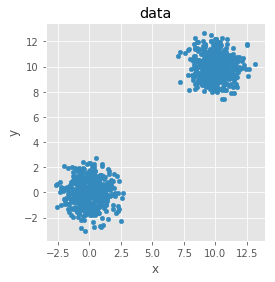

In [2]:
# データ
np.random.seed(0)
mean0 = np.array([0, 0])
cov0 = np.array([[1,0],[0,1]])
mean1 = np.array([10, 10])
cov1 = np.array([[1,0],[0,1]])
N = 1000
a = 0.5
X = pd.DataFrame(
    np.r_[
        sp.random.multivariate_normal(mean0, cov0, int(N*(1-a))),
        sp.random.multivariate_normal(mean1, cov1, int(N*a))
    ],
    columns=['x', 'y']
)
ax = X.plot(kind='scatter', x='x', y='y')
ax.set_aspect('equal')
ax.set_title('data')
# plt.savefig('1.png', bbox_inches='tight', pad_inches=0)

# シャッフルしてテストデータとする.
np.random.seed(0)
x = X.sample(frac=1).values.T
D = 2

# Dirichlet process base distribution
beta_0 = 1
m_0 = np.zeros((D, 1))
# m_0 = x[:, 0].reshape(D, 1)
W_0 = np.diag([1, 1])
nu_0 = 1.1

# Dirichlet process scaling parameter
alpha = 1

パラメータの初期化関数

In [3]:
def init():
    global mu_k, W_k, nu_k, beta_k, rho, K
    maxK = 100
    mu_k = np.zeros((maxK, D, 1))
    W_k = np.zeros((maxK, D, D))
    nu_k = np.zeros(maxK)
    beta_k = np.zeros(maxK)
    rho = np.zeros((N, maxK))

    K = 1
    rho[0, 0] = 1

Student's t distribution の PDF

In [4]:
# PDF of student's t distribution
def t_pdf(x, m, Lambda, df):
    D = len(m)
    m = m.reshape(D, 1)
    x = x.T

    return np.diag(
        np.exp(sp.special.loggamma(D/2. + df/2.) - sp.special.loggamma(df/2.)) *
        np.power(np.linalg.det(Lambda), 1/2.) / 
        np.power(np.pi * df, D/2.) *
        np.power(1 + (x-m).T@Lambda@(x-m)/df, -(D+df)/2.)
    )

パラメータの更新式

In [5]:
# eq15( k le K)
def eq15_1(w, D, x, mu_k, beta_k, nu_k, W_k):
    return w * t_pdf(
        x,
        mu_k,
        beta_k * (nu_k + 1 - D) * W_k / (1 + beta_k),
        (nu_k + 1 - D)
    )

# eq15(k = K + 1)
def eq15_2(alpha, D, x, m_0, beta_0, nu_0, W_0):
    m_1 = (x + beta_0 * m_0) / (1 + beta_0)
    beta_1 = 1 + beta_0
    W_1_inv = np.linalg.inv(W_0) + beta_0 / (1 + beta_0) * (x - m_0)@(x-m_0).T
    W_1 = np.linalg.inv(W_1_inv)
    nu_1 = 1 + nu_0
    
    return alpha / np.power(np.pi, D/2.) \
        * sp.special.gamma((nu_0+1.)/2.) \
        / sp.special.gamma((nu_0+1.-D)/2.) \
        * np.power(np.linalg.det(W_1), nu_1/2.) \
        / np.power(np.linalg.det(W_0), nu_0/2.) \
        * np.power(beta_0/beta_1, D/2.)

In [6]:
# eq.16(k .le. K)
def eq16_1(x, rho, i, k, m_0, beta_0, nu_0, W_0):
    r_k = rho[0:i+1, k].sum()

    x_bar = x@rho[0:i+1, k:k+1] / r_k
    S_k = np.sum([rho[j, k] * (x[:,j:j+1] - x_bar)@(x[:,j:j+1] - x_bar).T for j in range(i+1)], axis=0)
    
    m_k = (r_k * x_bar + beta_0 * m_0) / (r_k + beta_0)
    beta_k = r_k + beta_0
    W_k_inv = np.linalg.inv(W_0) \
        + r_k * beta_0 / (r_k + beta_0) * (x_bar - m_0)@(x_bar - m_0).T \
        + S_k
    W_k = np.linalg.inv(W_k_inv)
    nu_k = r_k + nu_0
    
    return m_k, beta_k, W_k, nu_k

# eq.16(k = K + 1)
def eq16_2(x, rho, i, k, m_0, beta_0, nu_0, W_0):
    m_k = (rho[i, k] * x + beta_0 * m_0) / (rho[i, k] + beta_0)
    beta_k = rho[i, k] + beta_0
    W_k_inv = np.linalg.inv(W_0) \
        + rho[i, k] * beta_0 / (rho[i, k] + beta_0) * (x - m_0)@(x - m_0).T
    W_k = np.linalg.inv(W_k_inv)
    nu_k = rho[i, k] + nu_0
    
    return m_k, beta_k, W_k, nu_k

merge関数も書いたが使わなかった.

In [7]:
def merge(eps=0.01):
    for i in range(K-1):
        for j in range(i+1, K):
            diff = np.abs(rho[:, i] - rho[:, j]).sum() / N
            if diff < eps:
                rho[:, i] += rho[:, j]
                rho[:, j] = 0

では計算実施.

In [8]:
init()
i=0
k=0
_mu_k, _beta_k, _W_k, _nu_k = eq16_2(x[:,i:i+1], rho, i, k, m_0, beta_0, nu_0, W_0)

mu_k[k] = _mu_k
beta_k[k] = _beta_k
W_k[k] = _W_k
nu_k[k] = _nu_k

# 試しに使ってみたプログレスバー
fp = FloatProgress(min=1, max=N-1)
display(fp)
for i in np.arange(1, N):
    for k in np.arange(K):
        w = rho[0:i, k].sum()
        if w == 0:
            rho[i, k] = 0
        else:
            rho[i, k] = eq15_1(w, D, x[:,i:i+1].T, mu_k[k], beta_k[k], nu_k[k], W_k[k])
    rho[i, K] = eq15_2(alpha, D, x[:,i:i+1], m_0, beta_0, nu_0, W_0)
    rho[i, 0:K+1] = rho[i, 0:K+1] / rho[i, 0:K+1].sum()
    
    if rho[i, K] > 0.01:
        for k in np.arange(K):
            if rho[0:i, k].sum() == 0: continue
            _mu_k, _beta_k, _W_k, _nu_k = eq16_1(x[:,0:i+1], rho, i, k, m_0, beta_0, nu_0, W_0)
            mu_k[k] = _mu_k
            beta_k[k] = _beta_k
            W_k[k] = _W_k
            nu_k[k] = _nu_k
        
        _mu_k, _beta_k, _W_k, _nu_k = eq16_2(x[:,i:i+1], rho, i, K, m_0, beta_0, nu_0, W_0)
        mu_k[K] = _mu_k
        beta_k[K] = _beta_k
        W_k[K] = _W_k
        nu_k[K] = _nu_k
        K = K + 1
    else:
        rho[i, K] = 0
        rho[i, 0:K] = rho[i, 0:K] / rho[i, 0:K].sum()
        for k in np.arange(K):
            if rho[0:i, k].sum() == 0: continue
            _mu_k, _beta_k, _W_k, _nu_k = eq16_1(x[:,0:i+1], rho, i, k, m_0, beta_0, nu_0, W_0)
            mu_k[k] = _mu_k
            beta_k[k] = _beta_k
            W_k[k] = _W_k
            nu_k[k] = _nu_k
    # 使わない
    # merge(0.001)
    fp.value = i

FloatProgress(value=1.0, max=999.0, min=1.0)

Component size: 25
Component weights: 
[0.53937356 0.0000303  0.45862318 0.00071761 0.00029765 0.00007885
 0.00012975 0.00008032 0.00004238 0.00005487 0.00004612 0.00003017
 0.00002602 0.00003653 0.00002051 0.00005822 0.00004662 0.00008584
 0.0000174  0.00002027 0.00005958 0.00003011 0.00001542 0.00006522
 0.00001349]
mu_k[0]: [[9.280608353057659], [9.270336064605647]]
mu_k[2]: [[0.13317886044658903], [0.14346155557160561]]


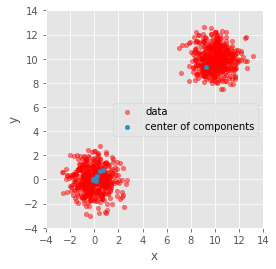

In [9]:
print(f'Component size: {K}')
np.set_printoptions(suppress=True)
print(f'Component weights: \n{rho.sum(axis=0)[0:K]/N}')
np.set_printoptions(suppress=False)
print(f'mu_k[0]: {mu_k[0].tolist()}')
print(f'mu_k[2]: {mu_k[1].tolist()}')

ax = X.plot(kind='scatter', x='x', y='y', color='red', alpha=0.5, label='data')
pd.DataFrame(
    mu_k.reshape(100, 2)[0:K], columns=['x','y']
).plot(kind='scatter', x='x', y='y', ax=ax, label='center of components').set_aspect('equal')
ax.set_xlim(-4, 14)
ax.set_ylim(-4, 14)
ax.set_xticks(np.arange(-4, 16, 2));
ax.set_yticks(np.arange(-4, 16, 2));

コンポーネント数は25となったが実質的にコンポーネントは2つ(0と２), それ以外はweightが低い. 
2つのコンポーネントの中心はそれらしいが, 右上のデータ群のコンポーネントの中心がすこしずれているようにも見える.

確率密度のコンタを可視化すると, 右上の分布の推定結果が変な形をしていることがわかる.

In [10]:
def plot(x=pd.DataFrame()):
    delta = 0.5
    xrange = np.array([-10, 15])
    yrange = np.array([-10, 15])
    gx = np.arange(*(xrange + delta/2), delta)
    gy = np.arange(*(yrange + delta/2), delta)
    gxx, gyy = np.meshgrid(gx, gy)
    gxgy = np.c_[gxx.ravel(), gyy.ravel()]

    zz = 0
    for k in range(K):
        w = rho[0:i, k].sum() / N
        if w < 1e-3: continue
        zz += w * t_pdf(
            gxgy,
            mu_k[k],
            beta_k[k] * (nu_k[k] + 1 - D) * W_k[k] / (1 + beta_k[k]),
            (nu_k[k] + 1 - D)
        )

    fig, ax = plt.subplots(ncols=1, figsize=(7, 7))
    cs = ax.contour(gxx, gyy, zz.reshape(len(gx), len(gy)), levels=[0.001, 0.005, 0.01, 0.05], colors=colors)
    plt.clabel(cs, inline=1, fontsize=15)
    if not x.empty:
        x.plot(kind='scatter', x='x', y='y', ax=ax, c=colors[0], alpha=0.5).set_aspect('equal')

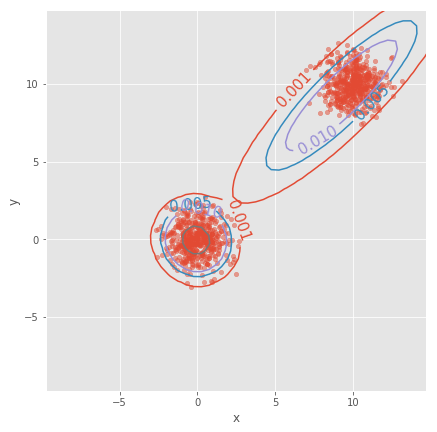

In [11]:
plot(pd.DataFrame(x.T, columns=['x', 'y']))

データ点ごとに$ \rho $ が最大となるグループをデータ点の属するグループとして, 可視化する. Gr.0に属する点に変なの(原点周辺のデータ点)が混じっている. 具体的にリストに出してみると, 並び順が若いデータ点がほとんどであった.

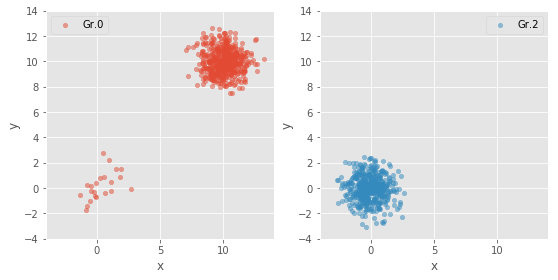

In [12]:
P = pd.DataFrame(x[:, :].T, columns=['x', 'y'])
P['group'] = rho.argmax(axis=1)
fig, axes = plt.subplots(ncols=P['group'].nunique(), figsize=(9, 7))

for i, k in enumerate(P['group'].unique()):
    P[P['group']==k].plot(kind='scatter', x='x', y='y', c=colors[i], label=f'Gr.{k}', alpha=0.5, ax=axes[i])
    axes[i].set_aspect('equal')
    axes[i].set_xlim(-4, 14)
    axes[i].set_ylim(-4, 14)
# plt.savefig('3.png', bbox_inches='tight', pad_inches=0)

In [13]:
P[(P.group == 0) & (P.x < 5)]

,x,y,group
2,-0.470033,-0.216731,0
6,-0.028182,0.428332,0
7,-0.439190,0.181338,0
8,0.605120,0.895556,0
10,-0.799422,0.240788,0
13,1.128594,0.496001,0
15,1.867559,0.906045,0
17,-0.764144,-1.437791,0
18,1.532779,1.469359,0
19,-0.098453,-0.663478,0


データに一度割り当てた $ \rho $ が以降更新されないことがやはり問題で, データが増えて生成された新規コンポーネントに, それ以前のデータは寄与できない. これにより推定結果は添字の若いデータやその並び順に依存する. また, 添字の若いデータ点のクラスタリングが信頼できないものになる.

上の図はかなりうまく行った方で, テストデータのクラスタ数を増やすともっとデタラメな結果が得られた.

論文によれば各イテレーションにおいてprune(weightの小さいコンポーネントを削除) and merge(各データにおける負担率の分布が近いコンポーネントをmerge)するともっと良くなるそうだが, それでは上の問題は解決できないのは明らか. 正直pruneやmergeよりsplitが必要ではないかと思う.


下は３成分でもっとだめだったやつ.

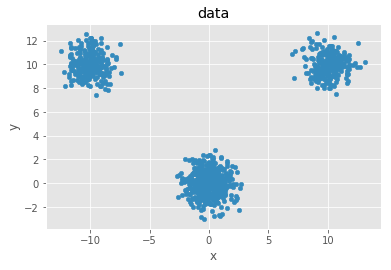

In [14]:
# データ
np.random.seed(0)
mean0 = np.array([0, 0])
cov0 = np.array([[1,0],[0,1]])
mean1 = np.array([10, 10])
cov1 = np.array([[1,0],[0,1]])
mean2 = np.array([-10, 10])
cov2 = np.array([[1,0],[0,1]])
N = 1000
a = 0.5
X = pd.DataFrame(
    np.r_[
        sp.random.multivariate_normal(mean0, cov0, int(N*(1-a))),
        sp.random.multivariate_normal(mean1, cov1, int(N*a/2)),
        sp.random.multivariate_normal(mean2, cov2, int(N*a/2))
    ],
    columns=['x', 'y']
)
ax = X.plot(kind='scatter', x='x', y='y')
ax.set_aspect('equal')
ax.set_title('data')
plt.savefig('1.png', bbox_inches='tight', pad_inches=0)

# シャッフルしてテストデータとする.
np.random.seed(0)
x = X.sample(frac=1).values.T
D = 2

# Dirichlet process base distribution
beta_0 = 1
m_0 = np.zeros((D, 1))
# m_0 = x[:, 0].reshape(D, 1)
W_0 = np.diag([1, 1])
nu_0 = 1.1

# Dirichlet process scaling parameter
alpha = 1

In [15]:
init()
i=0
k=0
_mu_k, _beta_k, _W_k, _nu_k = eq16_2(x[:,i:i+1], rho, i, k, m_0, beta_0, nu_0, W_0)

mu_k[k] = _mu_k
beta_k[k] = _beta_k
W_k[k] = _W_k
nu_k[k] = _nu_k

# 試しに使ってみたプログレスバー
fp = FloatProgress(min=1, max=N-1)
display(fp)
for i in np.arange(1, N):
    for k in np.arange(K):
        w = rho[0:i, k].sum()
        if w == 0:
            rho[i, k] = 0
        else:
            rho[i, k] = eq15_1(w, D, x[:,i:i+1].T, mu_k[k], beta_k[k], nu_k[k], W_k[k])
    rho[i, K] = eq15_2(alpha, D, x[:,i:i+1], m_0, beta_0, nu_0, W_0)
    rho[i, 0:K+1] = rho[i, 0:K+1] / rho[i, 0:K+1].sum()
    
    if rho[i, K] > 0.01:
        for k in np.arange(K):
            if rho[0:i, k].sum() == 0: continue
            _mu_k, _beta_k, _W_k, _nu_k = eq16_1(x[:,0:i+1], rho, i, k, m_0, beta_0, nu_0, W_0)
            mu_k[k] = _mu_k
            beta_k[k] = _beta_k
            W_k[k] = _W_k
            nu_k[k] = _nu_k
        
        _mu_k, _beta_k, _W_k, _nu_k = eq16_2(x[:,i:i+1], rho, i, K, m_0, beta_0, nu_0, W_0)
        mu_k[K] = _mu_k
        beta_k[K] = _beta_k
        W_k[K] = _W_k
        nu_k[K] = _nu_k
        K = K + 1
    else:
        rho[i, K] = 0
        rho[i, 0:K] = rho[i, 0:K] / rho[i, 0:K].sum()
        for k in np.arange(K):
            if rho[0:i, k].sum() == 0: continue
            _mu_k, _beta_k, _W_k, _nu_k = eq16_1(x[:,0:i+1], rho, i, k, m_0, beta_0, nu_0, W_0)
            mu_k[k] = _mu_k
            beta_k[k] = _beta_k
            W_k[k] = _W_k
            nu_k[k] = _nu_k
    # 使わない
    # merge(0.001)
    fp.value = i

FloatProgress(value=1.0, max=999.0, min=1.0)

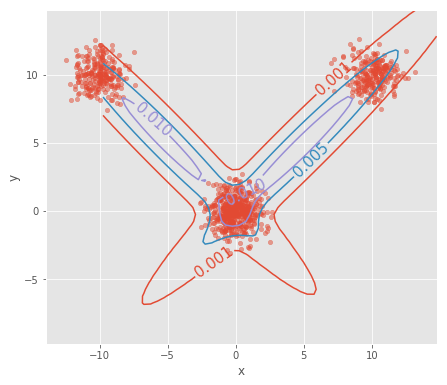

In [16]:
plot(pd.DataFrame(x.T, columns=['x', 'y']))

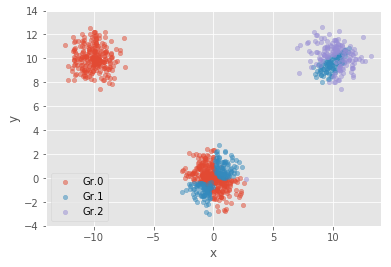

In [28]:
P = pd.DataFrame(x[:, :].T, columns=['x', 'y'])
P['group'] = rho.argmax(axis=1)
ax = None
for i, k in enumerate(sorted(P['group'].unique())):
    if ax:
        P[P['group']==k].plot(kind='scatter', x='x', y='y', c=colors[i], label=f'Gr.{k}', alpha=0.5, ax=ax)
    else:
        ax = P[P['group']==k].plot(kind='scatter', x='x', y='y', c=colors[i], label=f'Gr.{k}', alpha=0.5)
ax.set_aspect('equal')
ax.set_xlim(-14, 14)
_ = ax.set_ylim(-4, 14)

クラスタ数はあってるのに分類がダメです.

おわり.

## 1. Introduction

1. Dirichlet process mixture models(DPMM)はよい
    1. が,DPMMをMCMCで実現すると遅い. MCMCの手法は色々検討されているけど遅い. 大規模データに対して適用できない.
2. 平均場近似を用いたパラメータ推定法であるVariational inferenceを使うと, MCMCより高いパフォーマンスが出る
    1. 典型的なのはSBP(stick breaking process)を適当なコンポーネント数で打ち切る方法である(truncated-approximation).
    2. 適当なコンポーネント数は十分大きい必要があるので, 速いは速いが計算上の無駄が多い
3. 提案手法の特徴
    1. Variational inferenceと動的なコンポーネント数推定
    2. 逐次データに対応, online learning

## 2. Related Work

1. 効率的なBayesian nonparametric model の探求が流行っている. 
    1. Jain and Neal (2004) はsplit-merge で MCMCが局所解に停滞するのを避け高速化する手法を提案している.
    2. Dahl (2005) は 上のsequentiallyな実装を提案している(意味はわからん)
    3. この方向性の発展系としてHDP( Teh et al. (2007) )やBP-HMM( Hughes et al. (2012) )がある.
2. Variational inference はMCMCよりも高速. 中でもStochastic Variational Inference がすごい
    1. stochastic optimization(確率的最適化) と variational inference の合わせ技 Hoffman et al. (2012)
    2. Wang et al. (2011) がnon-parametricに拡張, Teh et al.(2007) が online-learning可能なHDPを提案
    3. Wang and Blei (2007)がtruncation-free variational inference を提案
3. Bryant and Sudderth (2012) online variational inference algorithm for HDP using mini-batch
    1. 本論文と似たような似たような問題意識
    2. 違いとして, Bryant and Sudderth (2012)はtopic model に特化している. こちらは汎用的.
    3. Bryant and Sudderth (2012)はランダムな初期値が必要. こちらは初期値不要
4. Nott et al. (2013) はVSUGSを提案している.
    1. 本論文に近いが, データの隠れ変数のみを推定している. 本論文は隠れ変数とコンポーネントのパラメタも推定している.
    2. Nott et al. (2013)はtruncation level Tってのが必要. 